## Webscrapping de Ámbito Financiero

In [1]:
# Manejar el tiempo y contar el tiempo de ejecución
import time

comienzo = time.perf_counter()

# Convertir los datos en DataFrame y transformar
import pandas as pd

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Opciones de Selenium, son típicas
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Ingresamos a la web de ambito financiero
    driver = webdriver.Chrome("chromedriver", options=chrome_options)
    driver.get("https://www.ambito.com/contenidos/riesgo-pais-historico.html")

    # Cliquear filtro desplegable de fecha de inicio
    filtro_fecha = driver.find_element(
        "xpath", "/html/body/main/div/div[1]/div[10]/div[1]/div[1]/input"
    )
    filtro_fecha.click()

    # Limpiamos y ponemos una fecha menor que la mínima que acepta la web para que nos dé el máximo que pueda
    filtro_fecha.clear()
    filtro_fecha.send_keys("05/06/1995")

    # Ejecutar el botón para filtrar la tabla esperando a que aparezca
    boton_filtrar = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located(
            ("xpath", "/html/body/main/div/div[1]/div[10]/div[1]/button")
        )
    )
    driver.execute_script("arguments[0].click();", boton_filtrar)

    # Esperar a que la tabla cargue, sin wait, sino toma los datos antes de que termine de cargar
    time.sleep(3)

    # Buscamos la tabla
    tabla = driver.find_element("xpath", "/html/body/main/div/div[1]/div[10]/table")

    # Tomamos el contenido HTML de la tabla
    tabla = tabla.get_attribute("outerHTML")

    # Desde el HTML creamos el dataframe con pandas
    riesgo_pais_df = pd.read_html(tabla)[0]
    riesgo_pais_df["Fecha"] = pd.to_datetime(riesgo_pais_df["Fecha"], dayfirst=True)
    riesgo_pais_df["Puntos"] = riesgo_pais_df["Puntos"] // 100

# Cerramos el navegador
finally:
    driver.quit()

# Exportamos a Excel
riesgo_pais_df.to_excel("Riesgo País.xlsx")

# Imprimir tiempo de ejecución y dataframe
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
{riesgo_pais_df}"""
)



La duración de la ejecución total fue de: 12.83 segundos.
          Fecha  Puntos
0    2023-06-22    2216
1    2023-06-21    2307
2    2023-06-20    2356
3    2023-06-19    2371
4    2023-06-16    2371
...         ...     ...
6325 1998-12-17     758
6326 1998-12-16     760
6327 1998-12-15     734
6328 1998-12-14     766
6329 1998-12-11     720

[6330 rows x 2 columns]


## Gráfico Lineal Histórico

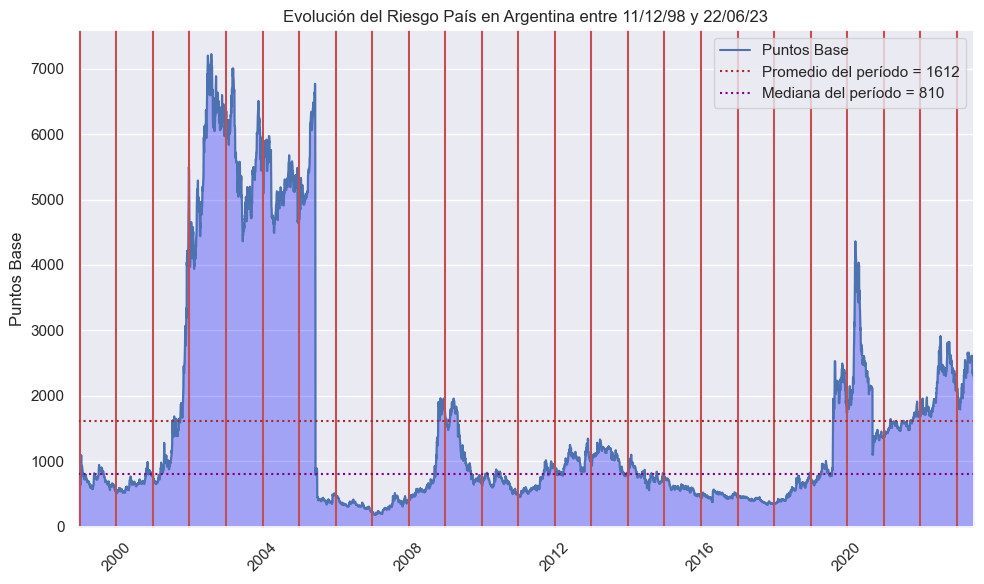


La duración de la ejecución total fue de: 13.65 segundos.



In [2]:
# Elegir estilo y crear figura
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar línea
sns.lineplot(
    data=riesgo_pais_df, x="Fecha", y="Puntos", color="b", ax=ax, label="Puntos Base"
)

fecha_min = riesgo_pais_df["Fecha"].min()
fecha_max = riesgo_pais_df["Fecha"].max()

# Configurar ejes
ax.set_xlabel("")
ax.set_ylabel("Puntos Base")
ax.set_title(
    f'Evolución del Riesgo País en Argentina entre {fecha_min.strftime("%d/%m/%y")} y {fecha_max.strftime("%d/%m/%y")}'
)

# Líneas verticales rojas al comenzar cada año
for year in range(
    riesgo_pais_df["Fecha"].min().year, riesgo_pais_df["Fecha"].max().year + 2
):
    date = pd.to_datetime(f"01/01/{year}", format="%d/%m/%Y")
    ax.axvline(date, color="r", linestyle="-")

# Ajustamos los límites del eje x e y
ax.set_xlim(fecha_min, fecha_max)
ax.set_ylim(0, riesgo_pais_df["Puntos"].max() * 1.05)


# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

# Rellenamos el espacio hacia abajo
plt.fill_between(
    riesgo_pais_df["Fecha"], riesgo_pais_df["Puntos"], color="blue", alpha=0.3
)

# Linea promedio total horizontal
promedio_periodo = riesgo_pais_df["Puntos"].mean()
ax.axhline(
    promedio_periodo,
    color="brown",
    linestyle=":",
    label=f"Promedio del período = {promedio_periodo:.0f}",
)

# Linea mediana total horizontal
mediana_periodo = riesgo_pais_df["Puntos"].median()
ax.axhline(
    mediana_periodo,
    color="purple",
    linestyle=":",
    label=f"Mediana del período = {mediana_periodo:.0f}",
)

# Activar leyenda
plt.legend()

# Descargar gráfico
plt.savefig(
    f'Riesgo País Histórico {fecha_min.strftime("%d-%m-%y")} a {fecha_max.strftime("%d-%m-%y")}.jpg'
)
# Mostrar gráfico
plt.tight_layout()
plt.show()

# Imprimir tiempo de ejecución
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
"""
)


## Gráficos Históricos divididos por año

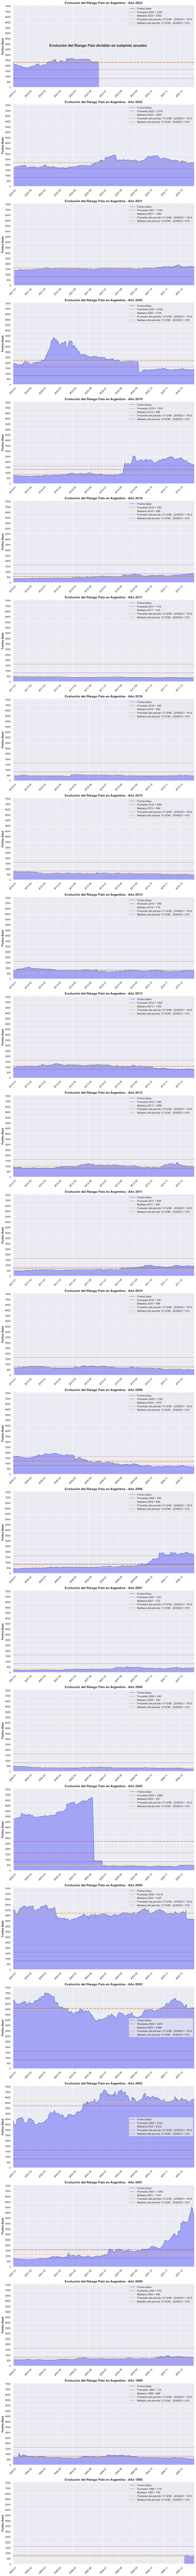


La duración de la ejecución total fue de: 26.97 segundos.



In [3]:
# Obtener los años únicos en el DataFrame
años = riesgo_pais_df["Fecha"].dt.year.unique()

# Crear figura y subplots por año, en forma vertical uno bajo el otro
fig, axs = plt.subplots(
    nrows=len(años), ncols=1, figsize=(12, len(años) * 6), sharex=False
)

# Iterar sobre los subplots y los años correspondientes
for ax, year in zip(axs, años):
    # Filtrar los datos por año
    df_year = riesgo_pais_df[riesgo_pais_df["Fecha"].dt.year == year]

    # Graficar línea
    sns.lineplot(
        data=df_year, x="Fecha", y="Puntos", color="b", ax=ax, label="Puntos Base"
    )

    # Configurar títulos de ejes
    ax.set_xlabel("")
    ax.set_ylabel("Puntos Base", fontweight="bold")

    # Establecer límites del eje X según el mínimo y el máximo de la fecha correspondiente
    ax.set_xlim(
        pd.to_datetime(f"01/01/{year}", format="%d/%m/%Y"),
        pd.to_datetime(f"31/12/{year}", format="%d/%m/%Y"),
    )

    # Rotar etiquetas del eje X para mayor legibilidad
    ax.tick_params(axis="x", rotation=45)

    # Configurar límites y ticks del eje Y, que vayan del 0 a 5% arriba del máximo
    ax.set_ylim(0, riesgo_pais_df["Puntos"].max() * 1.05)
    # Y que vayan de 250 en 250 los major ticks
    ax.yaxis.set_major_locator(plt.MultipleLocator(500))

    # Línea horizontal del promedio del año
    promedio_año = df_year["Puntos"].mean()
    ax.axhline(
        promedio_año,
        color="r",
        linestyle="-.",
        label=f"Promedio {year} = {promedio_año:.0f}",
    )

    # Línea horizontal de la mediana del año
    mediana_año = df_year["Puntos"].median()
    ax.axhline(
        mediana_año,
        color="gold",
        linestyle="-.",
        label=f"Mediana {year} = {mediana_año:.0f}",
    )

    # Linea promedio total horizontal
    promedio_periodo = riesgo_pais_df["Puntos"].mean()
    ax.axhline(
        promedio_periodo,
        color="brown",
        linestyle=":",
        label=f'Promedio del período {fecha_min.strftime("%d/%m/%y")} . {fecha_max.strftime("%d/%m/%y")} = {promedio_periodo:.0f}',
    )

    # Linea mediana total horizontal
    mediana_periodo = riesgo_pais_df["Puntos"].median()
    ax.axhline(
        mediana_periodo,
        color="purple",
        linestyle=":",
        label=f"Mediana del período {fecha_min.strftime('%d/%m/%y')} . {fecha_max.strftime('%d/%m/%y')} = {mediana_periodo:.0f}",
    )
    
    fig.suptitle(
    "Evolución del Riesgo País dividido en subplots anuales",
    fontweight="bold",
    fontsize=16
    )

    # Ajustar título del gráfico en negrita y con un poco más de tamaño
    ax.set_title(
        f"Evolución del Riesgo País en Argentina - Año {year}",
        fontweight="bold",
        fontsize=14,
    )

    # Rellenar el área hacia abajo
    ax.fill_between(df_year["Fecha"], df_year["Puntos"], color="blue", alpha=0.3)

    # Leyenda
    ax.legend()

# Ajustar espaciado vertical entre subplots
plt.subplots_adjust(hspace=0.5)

# Descargar gráfico
plt.savefig(
    f'Riesgo País anual {fecha_min.strftime("%d-%m-%y")} a {fecha_max.strftime("%d-%m-%y")}.jpg'
)

# Mostrar gráfico
plt.tight_layout()
plt.show()

# Imprimir tiempo de ejecución
print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
"""
)
